In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install rasterio scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 107.9 MB/s eta 0:00:00


In [3]:
import pandas as pd
import glob
import os
import shutil
import warnings
import seaborn as sns
import numpy as np
from scipy.stats import gmean
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import MinMaxScaler

In [4]:
#define function to remove outliers and find min max values to reduce skew
def trim_outliers_iteratively(values, max_skew=2, max_kurtosis=3.5):
    """
    Iteratively removes extreme min/max values until skewness <= 2 and kurtosis <= 3.5.
    Returns the trimmed dataset along with the final min and max.
    """
    values = values.dropna().values  # Ensure no NaNs
    while True:
        current_skew = skew(values)
        current_kurtosis = kurtosis(values)

        if abs(current_skew) <= max_skew and current_kurtosis <= max_kurtosis:
            break  # Stop if conditions are met

        # Remove min and max values
        min_val, max_val = values.min(), values.max()
        values = values[(values > min_val) & (values < max_val)]  # Trim extreme min/max

    return values, values.min(), values.max()

In [5]:
def boxplot_outlier_detection(values):
    """
    Detect outliers using the IQR method (1.5 IQR rule).
    """
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = np.percentile(values, 25)
    Q3 = np.percentile(values, 75)
    # Calculate IQR (Interquartile Range)
    IQR = Q3 - Q1
    # Define lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Return values that are within bounds
    return values[(values >= lower_bound) & (values <= upper_bound)], lower_bound, upper_bound

In [6]:
# merged_iso3_path = "/content/drive/MyDrive/CCRI/ccri_repo/data/CCRI_results_misc/Merged_Exposure_Data.csv"
# valid_iso3 = set(pd.read_csv(merged_iso3_path)['iso3'].unique())

plot distribution and skewness information to select min max values

processed : P2_electricity_access min: 8.4 max: 100.0
P2_electricity_access: skew=-1.769, kurtosis=2.120
IQR processed : P2_electricity_access min: 63.629762575000015 max: 121.82214245499999


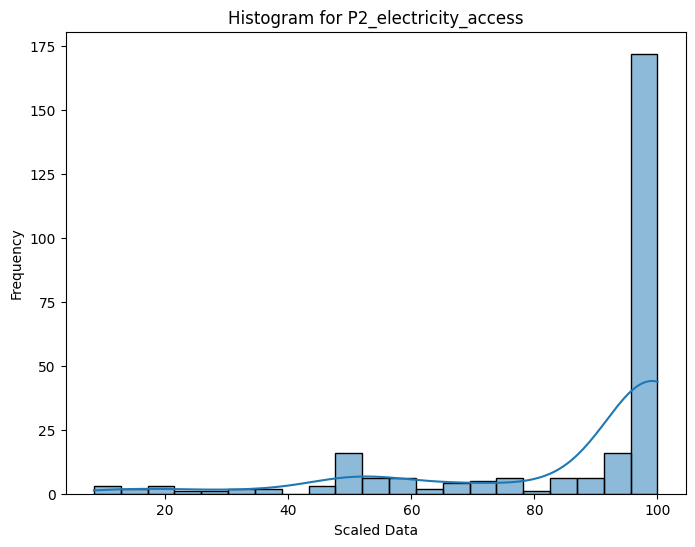

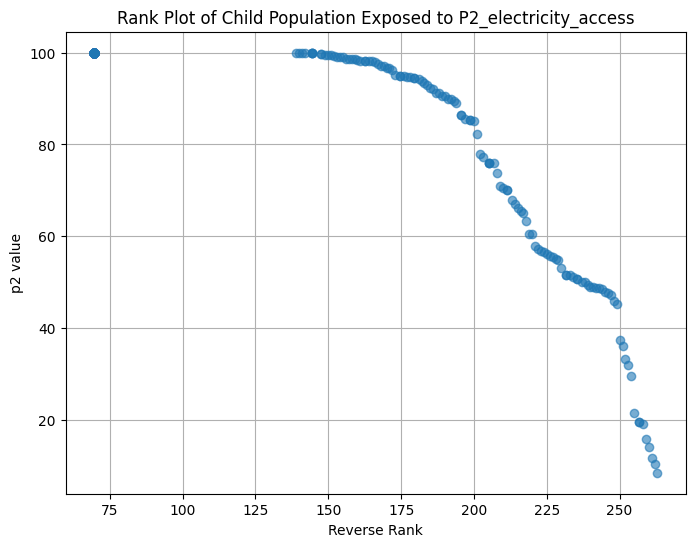

processed : P2_DTP1_access min: 48.0 max: 99.0
P2_DTP1_access: skew=-1.797, kurtosis=3.321
IQR processed : P2_DTP1_access min: 70.5 max: 114.5


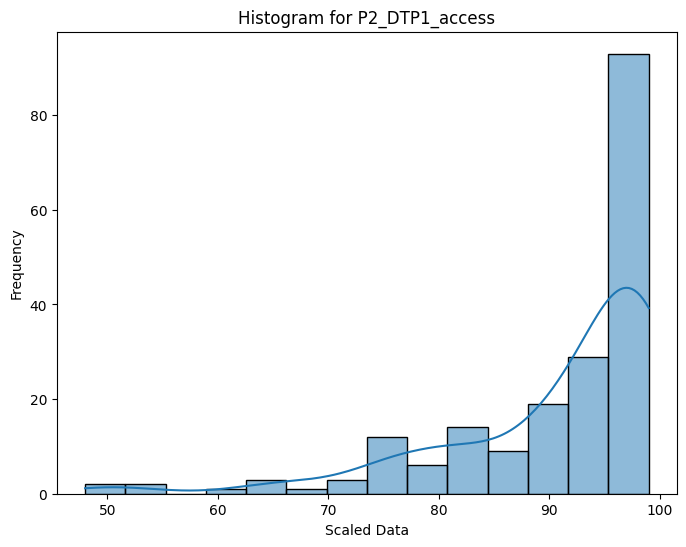

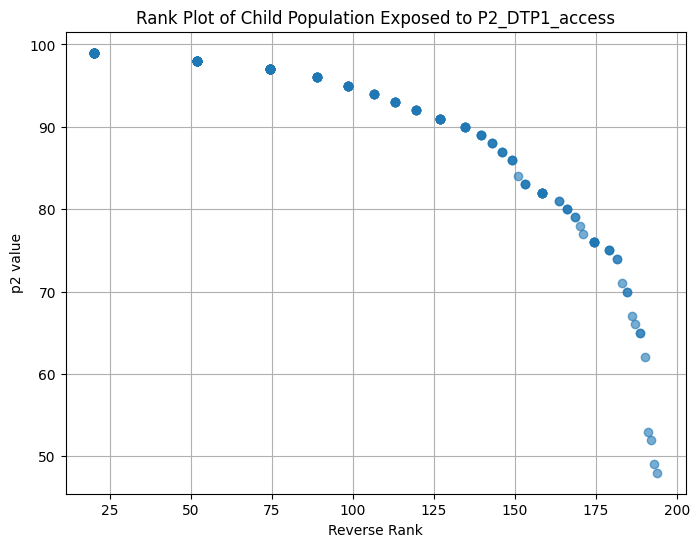

processed : P2_DTP3_access min: 39.0 max: 99.0
P2_DTP3_access: skew=-1.462, kurtosis=1.865
IQR processed : P2_DTP3_access min: 56.0 max: 120.0


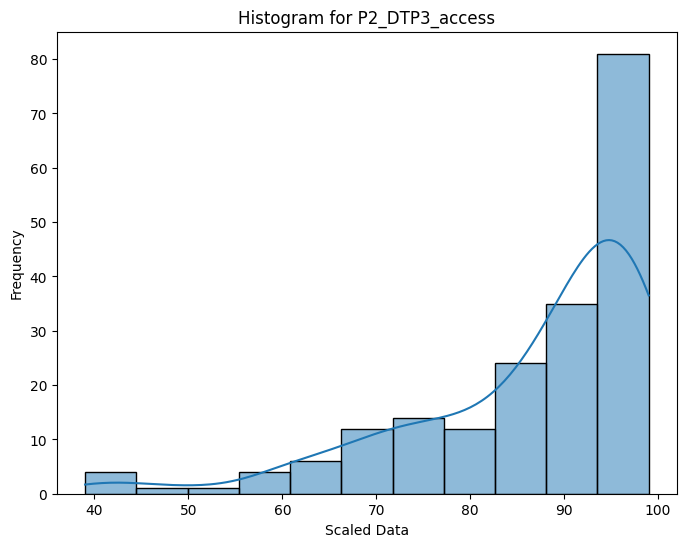

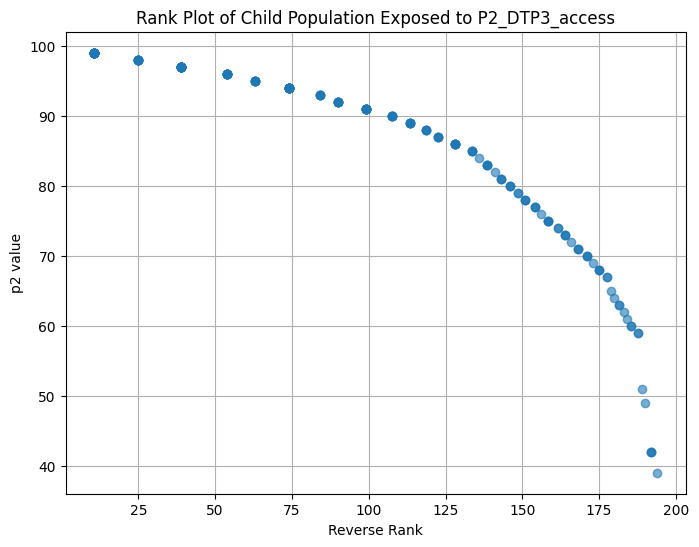

processed : P2_Skilled_birth_coverage min: 25.4 max: 100.0
P2_Skilled_birth_coverage: skew=-1.468, kurtosis=1.136
IQR processed : P2_Skilled_birth_coverage min: 46.22500000000002 max: 130.02499999999998


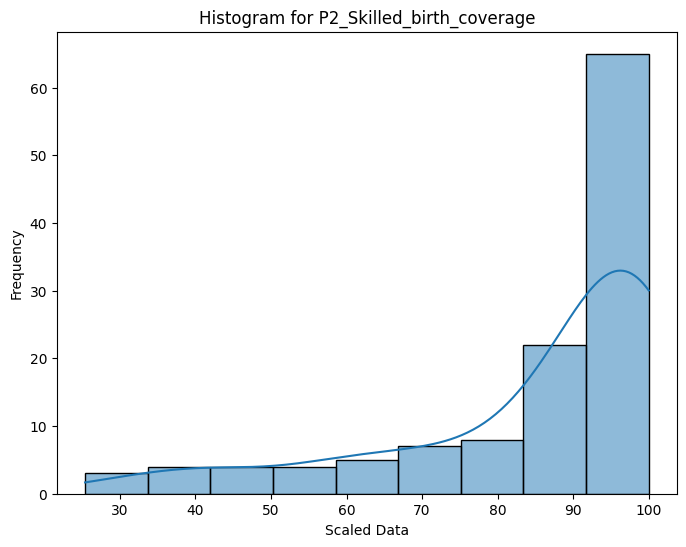

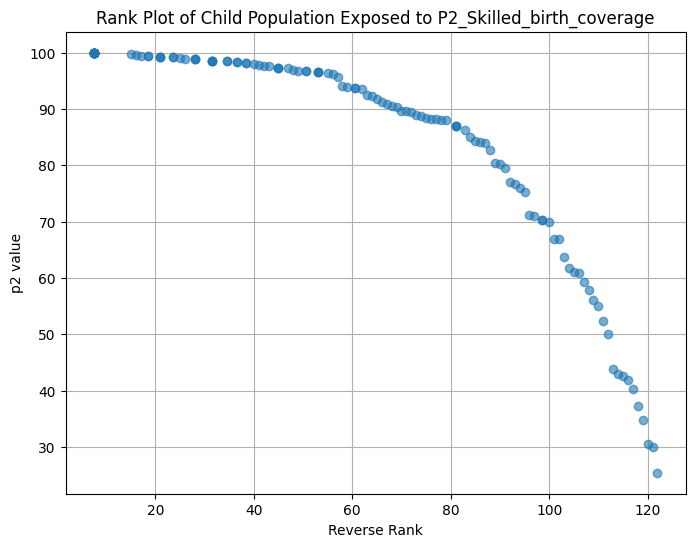

processed : P2_Stunting min: 1.0 max: 55.3
P2_Stunting: skew=0.949, kurtosis=0.096
IQR processed : P2_Stunting min: -21.150000000000002 max: 51.25


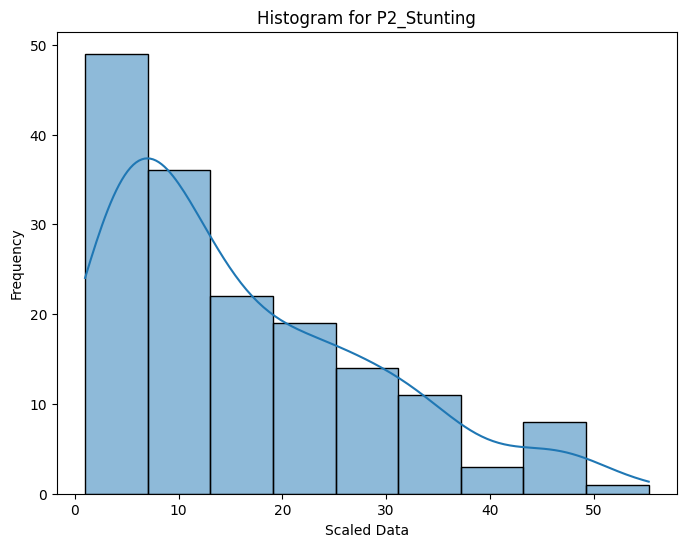

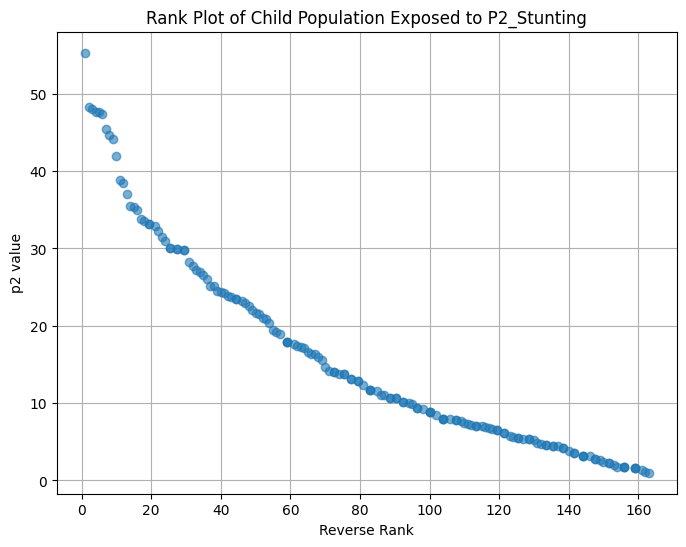

processed : P2_Child_Food_Poverty min: 1.2 max: 63.1
P2_Child_Food_Poverty: skew=0.603, kurtosis=-0.100
IQR processed : P2_Child_Food_Poverty min: -21.824999999999996 max: 62.775


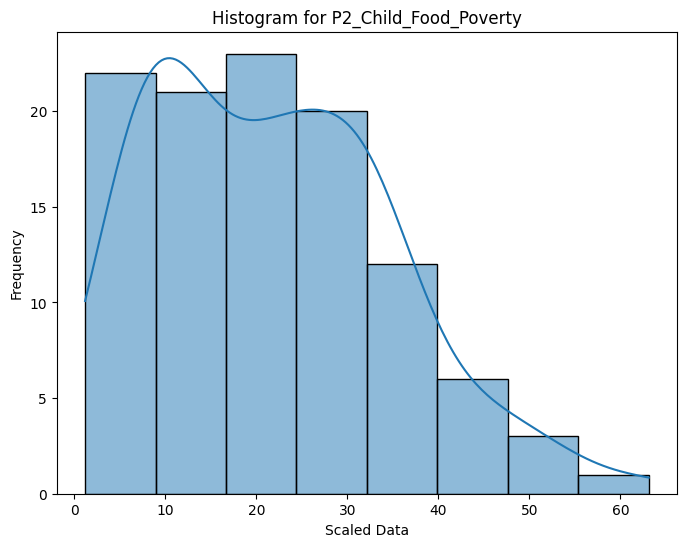

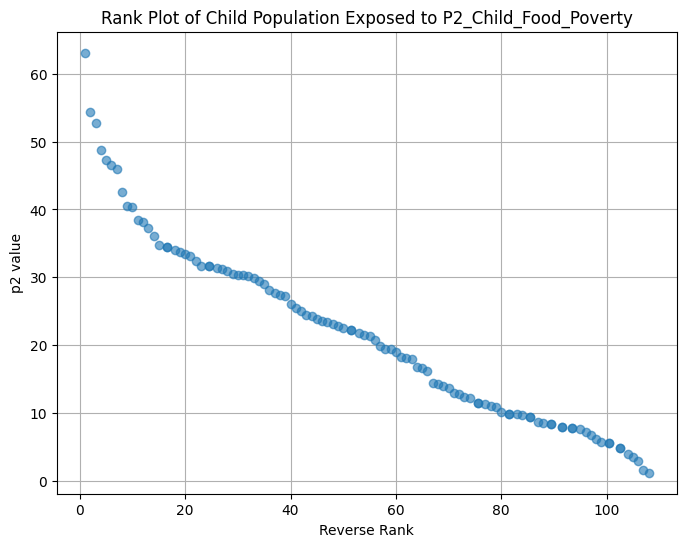

processed : P2_Lower_secondary_out_of_school min: 0.1221493 max: 69.712318
P2_Lower_secondary_out_of_school: skew=1.544, kurtosis=1.932
IQR processed : P2_Lower_secondary_out_of_school min: -23.819059625000005 max: 48.45818057500001


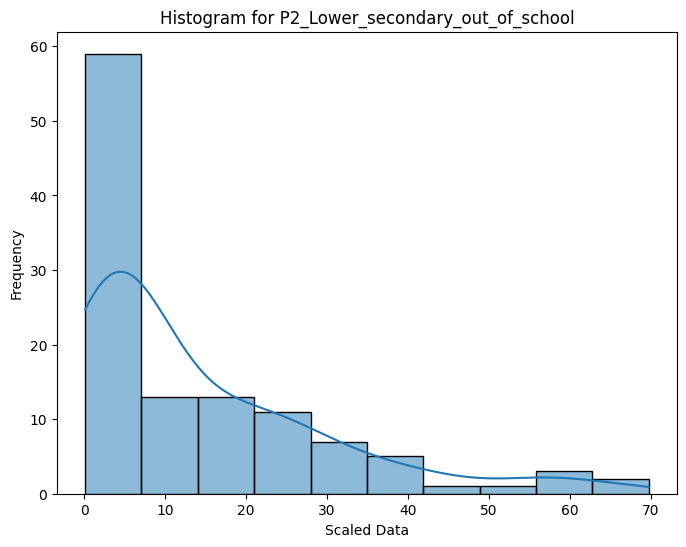

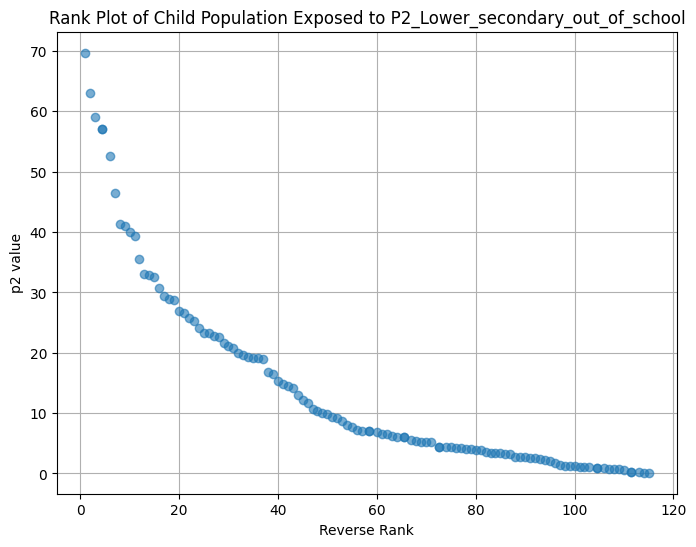

processed : P2_Lower_secondary_completion_rate min: 5.8079791 max: 99.800003
P2_Lower_secondary_completion_rate: skew=-0.329, kurtosis=-1.172
IQR processed : P2_Lower_secondary_completion_rate min: -22.357141999999996 max: 156.077902


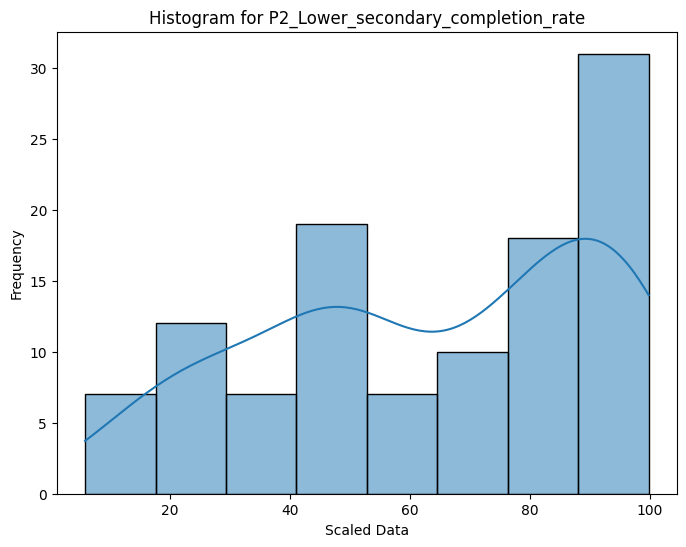

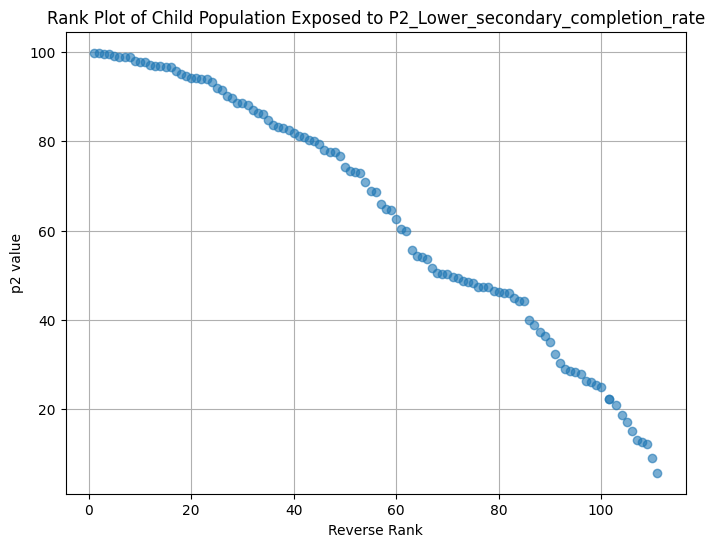

processed : P2_Learning_poverty min: 2.3305127620697 max: 98.5042114257812
P2_Learning_poverty: skew=0.341, kurtosis=-1.397
IQR processed : P2_Learning_poverty min: -86.64152646064771 max: 171.18396067619327


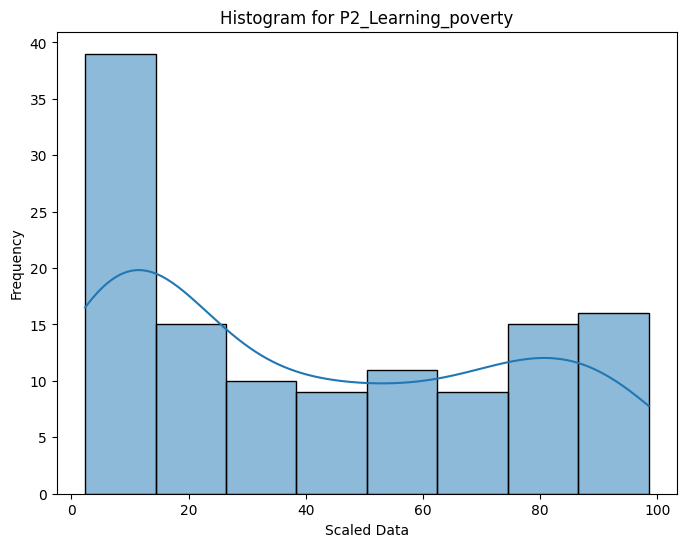

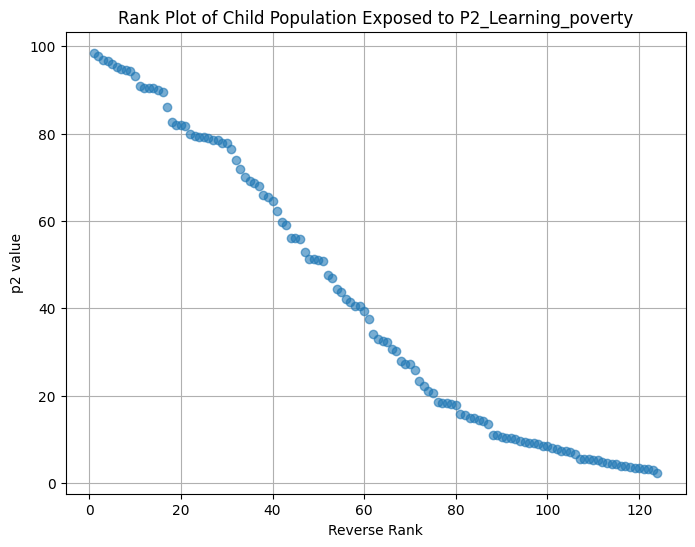

processed : P2_Child_labor min: 0.3 max: 56.6
P2_Child_labor: skew=1.103, kurtosis=1.118
IQR processed : P2_Child_labor min: -19.275 max: 44.525000000000006


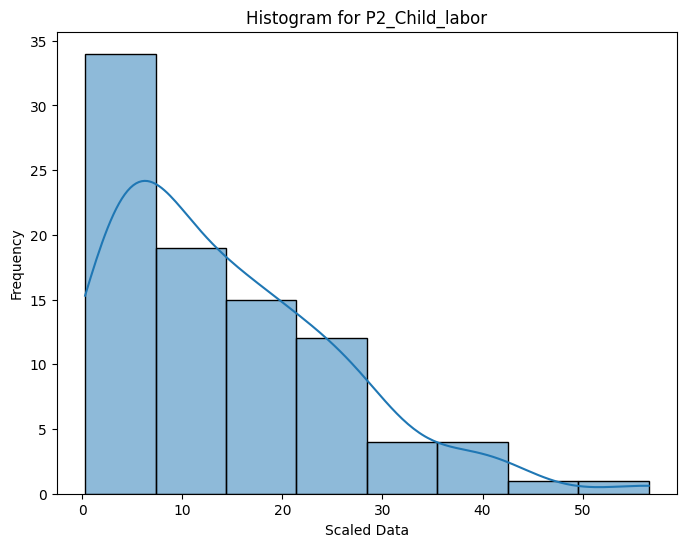

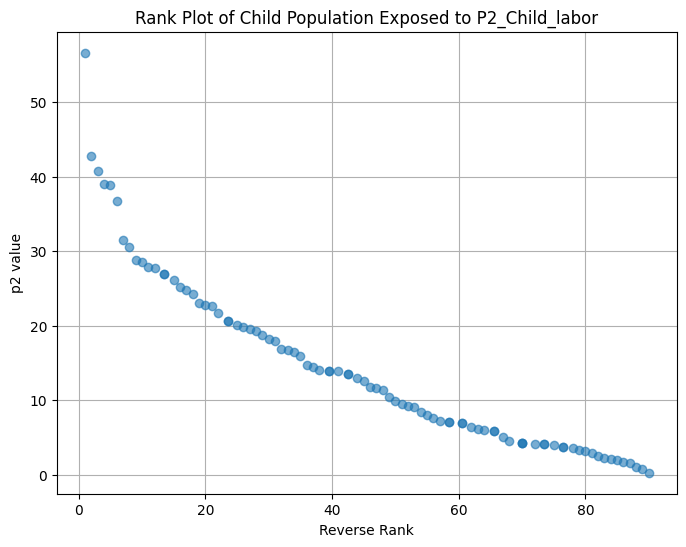

processed : P2_Child_marriage min: 16200.0 max: 10400000.0
P2_Child_marriage: skew=1.789, kurtosis=3.061
IQR processed : P2_Child_marriage min: -3944500.0 max: 6926700.0


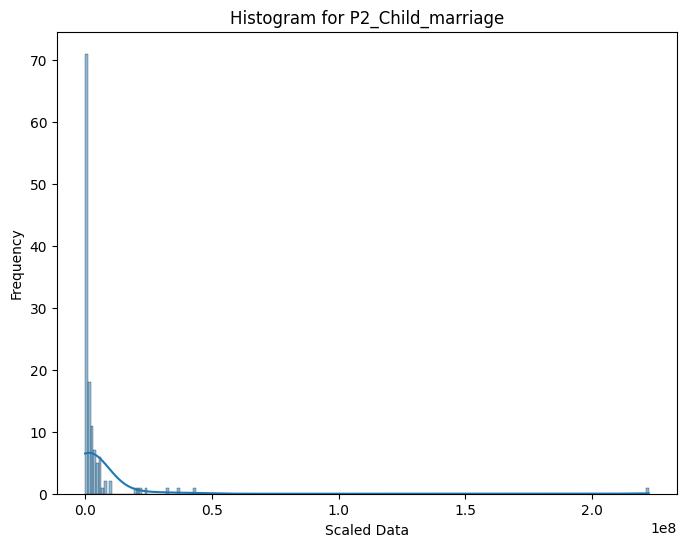

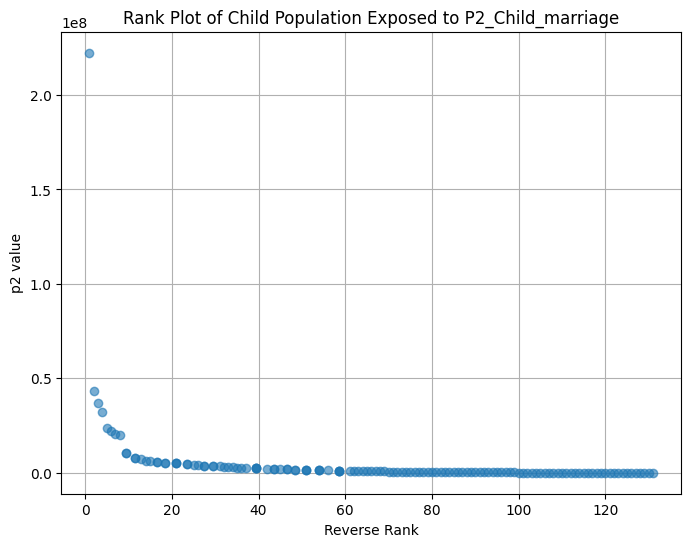

processed : P2_Child_poverty min: 2.6400771141052246 max: 83.46825408935547
P2_Child_poverty: skew=0.289, kurtosis=-0.795
IQR processed : P2_Child_poverty min: -29.098213195800792 max: 98.61497497558594


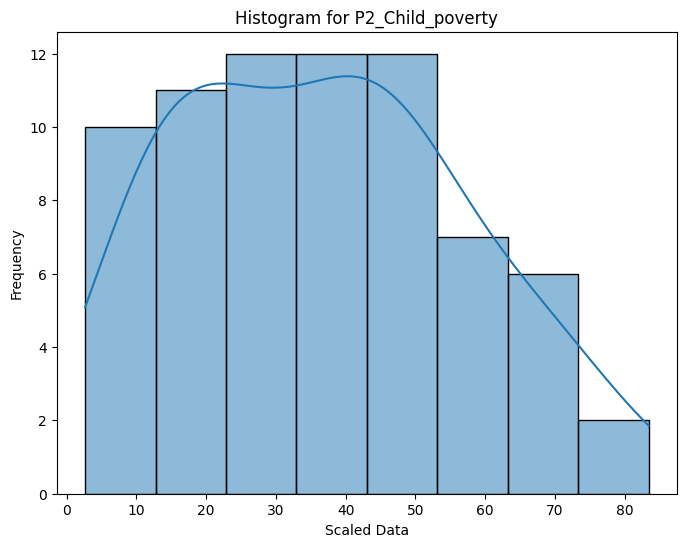

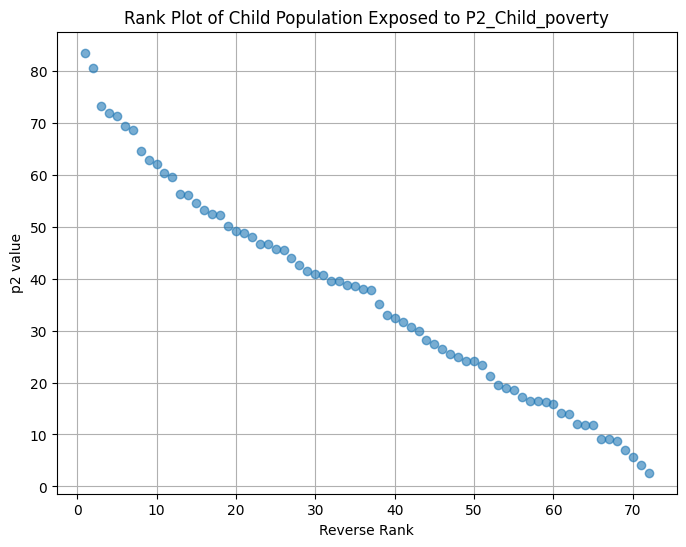

processed : P2_Under_five_covered_by_social_protection min: 0.0 max: 100.0
P2_Under_five_covered_by_social_protection: skew=0.690, kurtosis=-1.067
IQR processed : P2_Under_five_covered_by_social_protection min: -86.37500000000001 max: 158.425


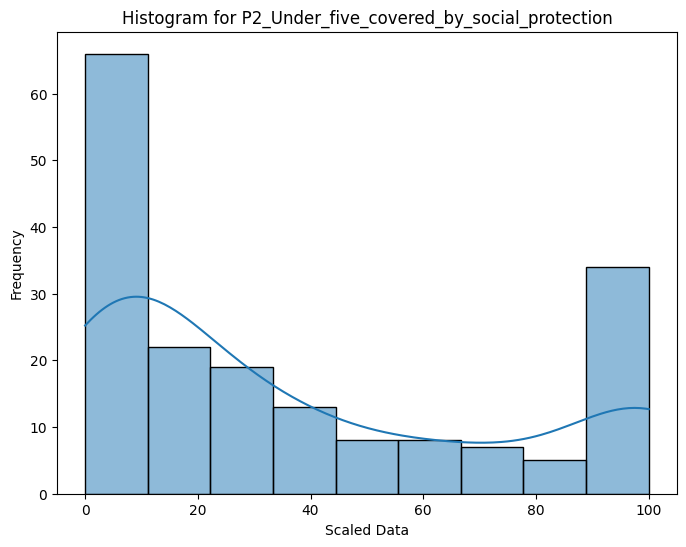

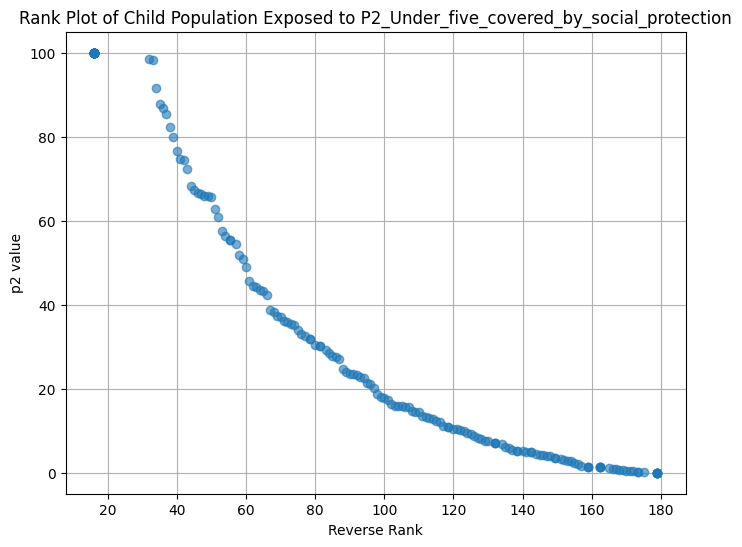

processed : P2_Under_five_mortality min: 0.487271124408217 max: 18.3228115123205
P2_Under_five_mortality: skew=1.881, kurtosis=2.883
IQR processed : P2_Under_five_mortality min: -6.155368725127206 max: 12.316462644731883


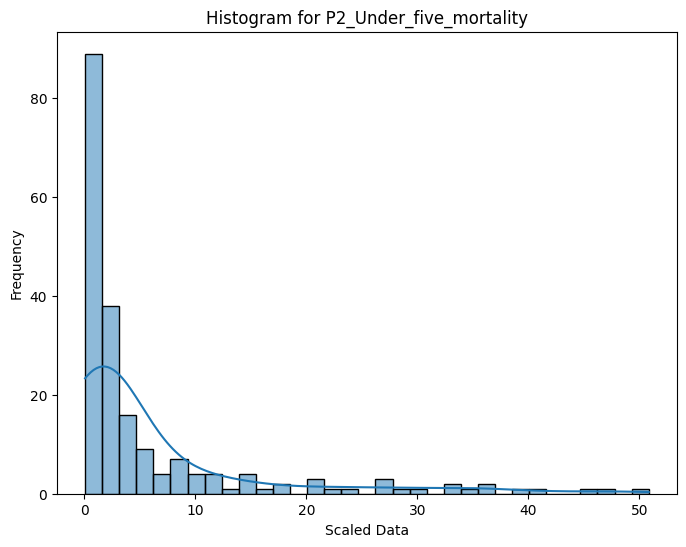

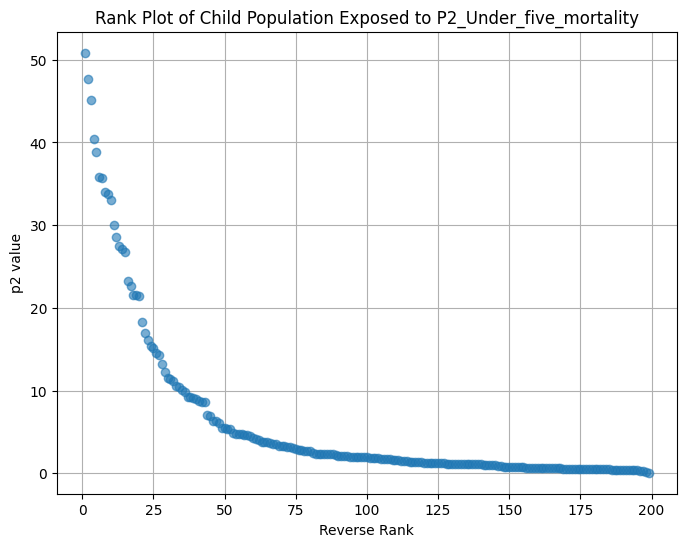

processed : P2_Basic_hygiene min: 0.956270005 max: 100.0
P2_Basic_hygiene: skew=-0.059, kurtosis=-1.670
IQR processed : P2_Basic_hygiene min: -76.04470113999999 max: 183.40937226


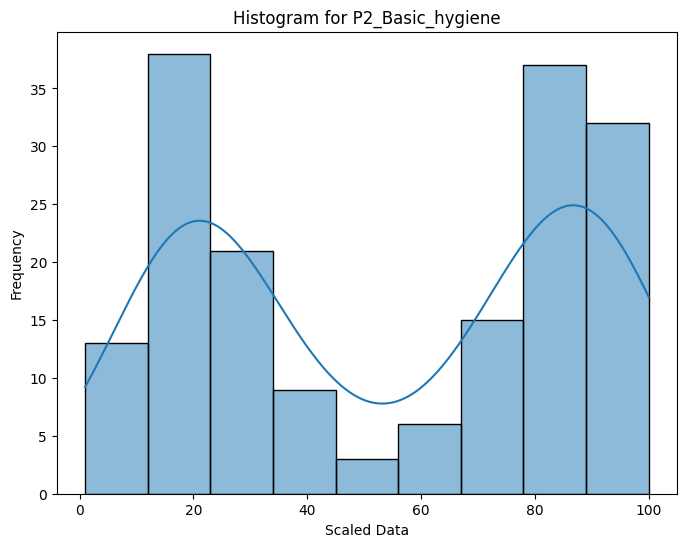

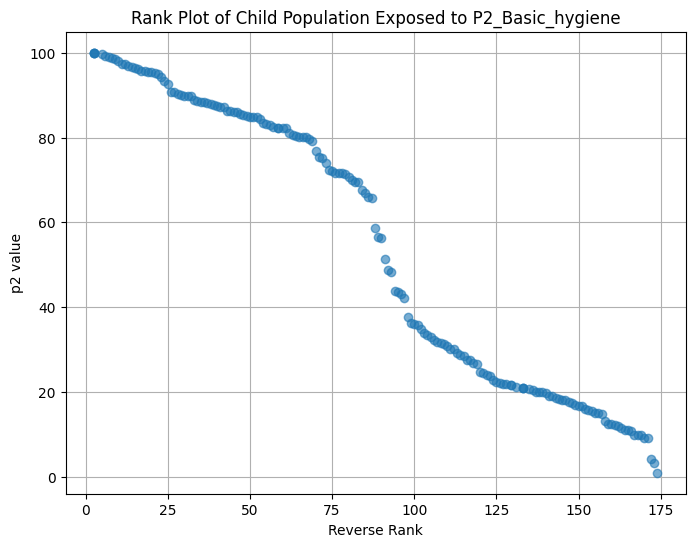

processed : P2_At-least_basic_drinking_water min: 13.82322112 max: 100.0
P2_At-least_basic_drinking_water: skew=-1.250, kurtosis=0.488
IQR processed : P2_At-least_basic_drinking_water min: 33.915594625 max: 139.08464322499998


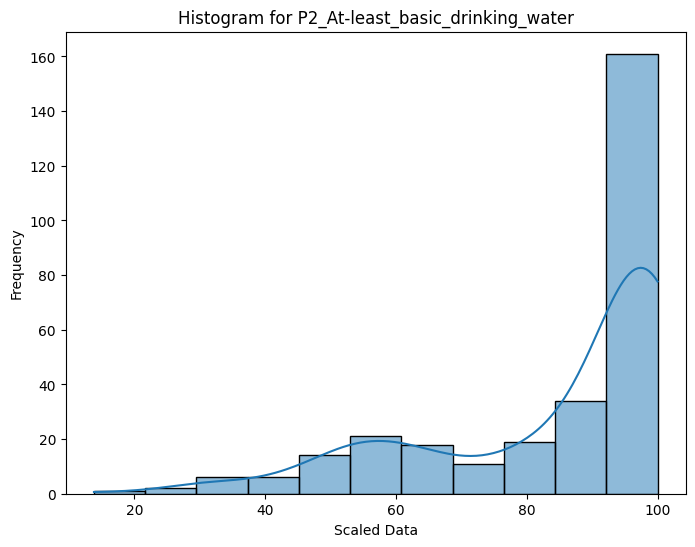

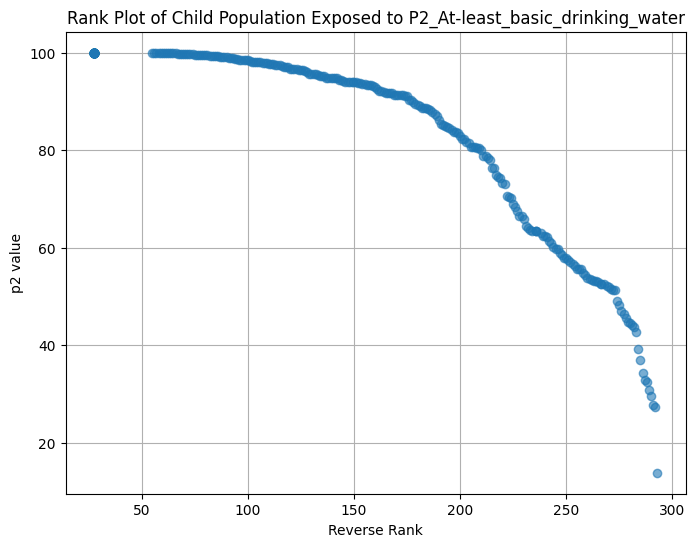

processed : P2_At-least_basic_sanitation min: 4.512961008 max: 100.0
P2_At-least_basic_sanitation: skew=-0.934, kurtosis=-0.658
IQR processed : P2_At-least_basic_sanitation min: -25.037855982500005 max: 173.06391361750002


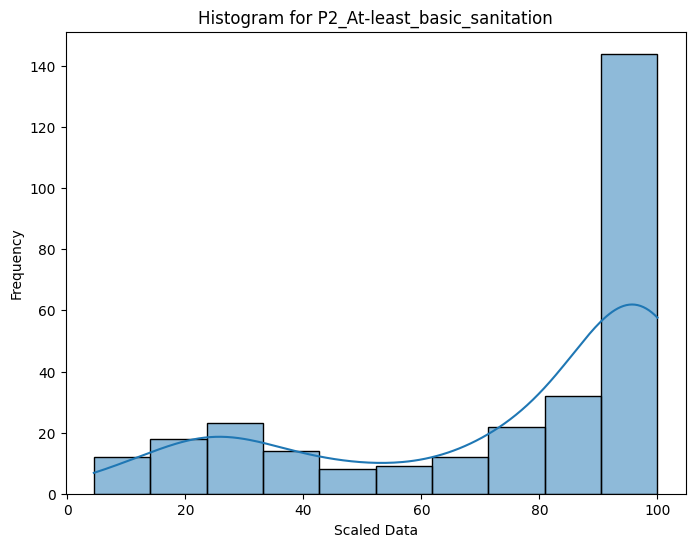

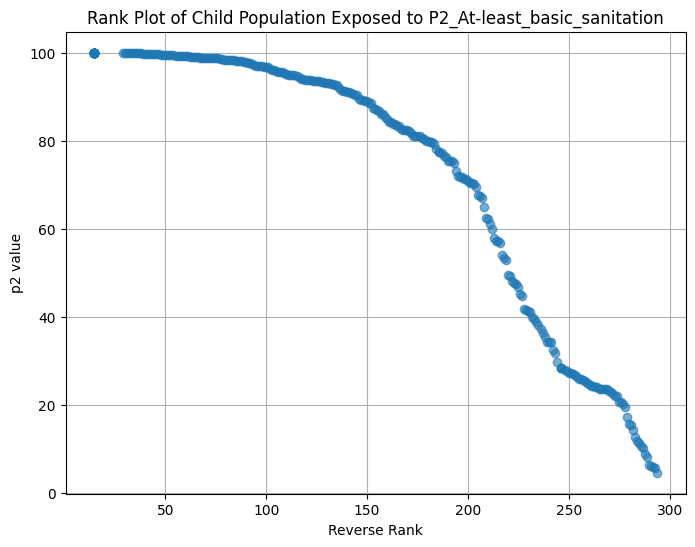

In [7]:
# Define source and destination folder paths
data_dir = '/content/drive/MyDrive/CCRI/ccri_repo/data'

source_folder = f"{data_dir}/p2_vulnerability/"

# Get all copied CSV files
csv_files = glob.glob(os.path.join(source_folder, "*.csv"))

# List of variables to reverse normalize
reverse_columns = [
    'P2_Skilled_birth_coverage',
    'P2_Lower_secondary_completion_rate',
    'P2_DTP1_access',
    'P2_DTP3_access',
    'P2_At-least_basic_drinking_water',
    'P2_At-least_basic_sanitation',
    'P2_Basic_hygiene',
    'P2_electricity_access',
    'P2_Under_five_covered_by_social_protection'
]
# Initialize an empty DataFrame for merged results
merged_df = pd.DataFrame()

for file in csv_files:
    df = pd.read_csv(file)
    # df =  df[df['iso3'].isin(valid_iso3)]

    if 'iso3' not in df.columns or 'value' not in df.columns:
        continue  # Skip files missing required columns
    # Normalize 'value' column
    df = df[['iso3', 'value']].dropna()
    # Apply iterative trimming
    trimmed_values, min_trimmed, max_trimmed = trim_outliers_iteratively(df['value'])
    iqr_trimmed_values, iqr_lower_bound, iqr_upper_bound = boxplot_outlier_detection(df['value'])

    # Extract filename for column naming
    filename = os.path.basename(file).replace(".csv", "")

    print(f"processed : {filename} min: {min_trimmed} max: {max_trimmed}" )
    current_skew = skew(trimmed_values)
    current_kurtosis = kurtosis(trimmed_values)
    print(f"{filename}: skew={current_skew:.3f}, kurtosis={current_kurtosis:.3f}")
    print(f"IQR processed : {filename} min: {iqr_lower_bound} max: {iqr_upper_bound}" )

    # Plot histogram and normality check
    plt.figure(figsize=(8, 6))
    sns.histplot(df['value'], kde=True)
    plt.title(f"Histogram for {filename}")
    plt.xlabel("Scaled Data")
    plt.ylabel("Frequency")
    plt.show()

    # Compute ranks in reverse order
    df['rank_reverse'] = df['value'].rank(method='average', ascending=False)
    plt.figure(figsize=(8, 6))
    plt.plot(df['rank_reverse'], df['value'], marker='o', linestyle='', alpha=0.6)
    plt.xlabel("Reverse Rank")
    plt.ylabel("p2 value")
    plt.title(f"Rank Plot of Child Population Exposed to {filename}")
    plt.grid(True)
    plt.show()



Normalize and obtain min max value for P2 indicators

In [8]:
# Define source and destination folder paths
source_folder = f"{data_dir}/p2_vulnerability/"
destination_folder = f"{data_dir}/CCRI_results_misc/"

# Get all copied CSV files
csv_files = glob.glob(os.path.join(source_folder, "*.csv"))
for file in csv_files:
    print(file)

/content/drive/MyDrive/CCRI/ccri_repo/data/p2_vulnerability/P2_electricity_access.csv
/content/drive/MyDrive/CCRI/ccri_repo/data/p2_vulnerability/P2_DTP1_access.csv
/content/drive/MyDrive/CCRI/ccri_repo/data/p2_vulnerability/P2_DTP3_access.csv
/content/drive/MyDrive/CCRI/ccri_repo/data/p2_vulnerability/P2_Skilled_birth_coverage.csv
/content/drive/MyDrive/CCRI/ccri_repo/data/p2_vulnerability/P2_Stunting.csv
/content/drive/MyDrive/CCRI/ccri_repo/data/p2_vulnerability/P2_Child_Food_Poverty.csv
/content/drive/MyDrive/CCRI/ccri_repo/data/p2_vulnerability/P2_Lower_secondary_out_of_school.csv
/content/drive/MyDrive/CCRI/ccri_repo/data/p2_vulnerability/P2_Lower_secondary_completion_rate.csv
/content/drive/MyDrive/CCRI/ccri_repo/data/p2_vulnerability/P2_Learning_poverty.csv
/content/drive/MyDrive/CCRI/ccri_repo/data/p2_vulnerability/P2_Child_labor.csv
/content/drive/MyDrive/CCRI/ccri_repo/data/p2_vulnerability/P2_Child_marriage.csv
/content/drive/MyDrive/CCRI/ccri_repo/data/p2_vulnerability/P2_

In [9]:
# Define source and destination folder paths
source_folder = f"{data_dir}/p2_vulnerability/"
destination_folder = f"{data_dir}/CCRI_results_misc/"

# Get all copied CSV files
csv_files = glob.glob(os.path.join(source_folder, "*.csv"))

# List of variables to reverse normalize
reverse_columns = [
    'P2_Skilled_birth_coverage',
    'P2_Lower_secondary_completion_rate',
    'P2_DTP1_access',
    'P2_DTP3_access',
    'P2_At-least_basic_drinking_water',
    'P2_At-least_basic_sanitation',
    'P2_Basic_hygiene',
    'P2_electricity_access',
    'P2_Under_five_covered_by_social_protection'
]

# Initialize an empty DataFrame for merged results
total_population_file = f"{source_folder}/P2_Under_five_mortality.csv"

# Load total child population data
merged_df = pd.read_csv(total_population_file, usecols=['iso3'])



for file in csv_files:
    df = pd.read_csv(file)
    # df =  df[df['iso3'].isin(valid_iso3)]
    #drop values acquired before 2015
    df = df[df['time_period'] >= 2015]
    # Extract filename for column naming
    filename = os.path.basename(file).replace(".csv", "")

    if 'iso3' not in df.columns or 'value' not in df.columns:
        continue  # Skip files missing required columns
    # Normalize 'value' column
    df = df[['iso3', 'value']].dropna()

    df_min_max = pd.read_csv(os.path.join(destination_folder,'p2_min_max.csv'))

    df_min_max['filename'] = df_min_max['filename'].astype(str).str.strip()
    filename = str(filename).strip()

    min_trimmed = df_min_max.loc[(df_min_max['filename'] == filename),'min'].values[0]
    max_trimmed = df_min_max.loc[(df_min_max['filename'] == filename),'max'].values[0]

    # clip to min max
    df['value'] = np.clip(df['value'], min_trimmed, max_trimmed)

    # Normalize using final min/max
    scaler = MinMaxScaler(feature_range=(0, 10))  # scale to 0–10
    df['value_normalized'] = scaler.fit_transform(df[['value']]).flatten()

    df['min'] = min_trimmed
    df['max'] = max_trimmed


    # Reverse normalization for specific columns
    if filename in reverse_columns:
        df['value_normalized'] = 10 - df['value_normalized']  # Reverse normalize & and scale 0 to 10

    # Rename column
    df.rename(columns={'value_normalized': filename + '_value_normalized'}, inplace=True)
    df.rename(columns={'min': filename + '_min'}, inplace=True)
    df.rename(columns={'max': filename + '_max'}, inplace=True)

    print(f"processed : {filename} | min: {min_trimmed} | max: {max_trimmed}" )

    # Merge with the main DataFrame (use suffixes to avoid column name conflicts)
    if merged_df.empty:
        merged_df = df[['iso3', filename + '_value_normalized']]
    else:
        merged_df = merged_df.merge(df[['iso3', filename + '_value_normalized']],
                                     on='iso3', how='left', suffixes=('', f'_{filename}'))


pillar2_columns = [col for col in merged_df.columns if col.endswith('_value_normalized')]
#Keep only rows with at least 12 non-NaN values across pillar2_columns



processed : P2_electricity_access | min: 10 | max: 100
processed : P2_DTP1_access | min: 45 | max: 98
processed : P2_DTP3_access | min: 40 | max: 98
processed : P2_Skilled_birth_coverage | min: 25 | max: 100
processed : P2_Stunting | min: 1 | max: 50
processed : P2_Child_Food_Poverty | min: 0 | max: 70
processed : P2_Lower_secondary_out_of_school | min: 1 | max: 70
processed : P2_Lower_secondary_completion_rate | min: 1 | max: 100
processed : P2_Learning_poverty | min: 3 | max: 98
processed : P2_Child_labor | min: 1 | max: 40
processed : P2_Child_marriage | min: 0 | max: 5000000
processed : P2_Child_poverty | min: 3 | max: 83
processed : P2_Under_five_covered_by_social_protection | min: 0 | max: 100
processed : P2_Under_five_mortality | min: 1 | max: 100
processed : P2_Basic_hygiene | min: 4 | max: 100
processed : P2_At-least_basic_drinking_water | min: 35 | max: 100
processed : P2_At-least_basic_sanitation | min: 10 | max: 100


In [10]:
print("Unique iso3 in merged_df:", merged_df['iso3'].nunique())
print("Unique iso3 in df:", df['iso3'].nunique())

Unique iso3 in merged_df: 199
Unique iso3 in df: 294


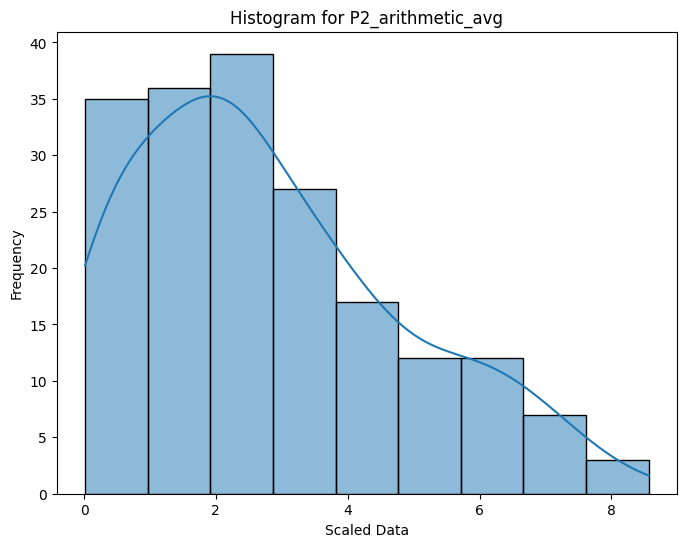

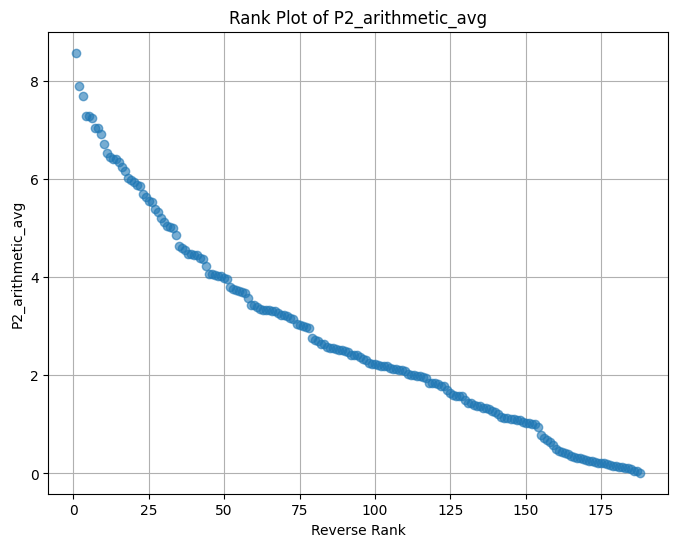

Processed data saved to /content/drive/MyDrive/CCRI/ccri_repo/data/CCRI_results_misc/P2_Merged_Normalized_avg.csv


In [11]:
# Set the threshold for minimum percentage of non-missing values (e.g., 70%)
threshold = 0.4

merged_df = merged_df[
    (merged_df[pillar2_columns].notna().sum(axis=1) / len(pillar2_columns)) >= threshold
]


# Filter columns that end with '_value_normalized'
health_prefixes = ['P2_DTP1_access', 'P2_DTP3_access', 'P2_Skilled_birth_coverage', 'P2_electricity_access']
health_columns = [col for col in merged_df.columns if any(col.startswith(prefix) for prefix in health_prefixes)]
nutrition_prefixes = ['P2_Stunting', 'P2_Child_Food_Poverty']
nutrition_columns = [col for col in merged_df.columns if any(col.startswith(prefix) for prefix in nutrition_prefixes)]
wash_prefixes = ['P2_At-least_basic_drinking_water', 'P2_At-least_basic_sanitation', 'P2_Basic_hygiene']
wash_columns = [col for col in merged_df.columns if any(col.startswith(prefix) for prefix in wash_prefixes)]
education_prefixes = ['P2_Lower_secondary_out_of_school', 'P2_Lower_secondary_completion_rate', 'P2_Learning_poverty']
education_columns = [col for col in merged_df.columns if any(col.startswith(prefix) for prefix in education_prefixes)]
protection_prefixes = ['P2_Child_labor', 'P2_Child_marriage']
protection_columns = [col for col in merged_df.columns if any(col.startswith(prefix) for prefix in protection_prefixes)]
poverty_prefixes = ['P2_Child_poverty', 'P2_Under_five_covered_by_social_protection']
poverty_columns = [col for col in merged_df.columns if any(col.startswith(prefix) for prefix in poverty_prefixes)]
survival_prefixes = ['P2_Under_five_mortality']
survival_columns = [col for col in merged_df.columns if any(col.startswith(prefix) for prefix in survival_prefixes)]

with warnings.catch_warnings():
  warnings.simplefilter("ignore", category=RuntimeWarning)
  health_avg = merged_df[health_columns].apply(np.nanmean, axis=1)
  nutrition_avg = merged_df[nutrition_columns].apply(np.nanmean, axis=1)
  wash_avg = merged_df[wash_columns].apply(np.nanmean, axis=1)
  education_avg = merged_df[education_columns].apply(np.nanmean, axis=1)
  protection_avg = merged_df[protection_columns].apply(np.nanmean, axis=1)
  poverty_avg = merged_df[poverty_columns].apply(np.nanmean, axis=1)
  survival_avg = merged_df[survival_columns].apply(np.nanmean, axis=1)

# Combine all into a DataFrame
domains_df = pd.DataFrame({
    'health': health_avg,
    'nutrition': nutrition_avg,
    'wash': wash_avg,
    'education': education_avg,
    'protection': protection_avg,
    'poverty': poverty_avg,
    'survival': survival_avg
})


merged_df = merged_df.copy()
merged_df.loc[:, "P2_arithmetic_avg"] = domains_df.apply(np.nanmean, axis=1)

# Plot histogram and normality check
plt.figure(figsize=(8, 6))
sns.histplot(merged_df['P2_arithmetic_avg'], kde=True)
plt.title(f"Histogram for P2_arithmetic_avg")
plt.xlabel("Scaled Data")
plt.ylabel("Frequency")
plt.show()

# Compute ranks in reverse order
# merged_df['rank_reverse'] = merged_df['P2_arithmetic_avg'].rank(method='average', ascending=False)
merged_df.loc[:, "rank_reverse"] = merged_df["P2_arithmetic_avg"].rank(method='average', ascending=False)

plt.figure(figsize=(8, 6))
plt.plot(merged_df['rank_reverse'], merged_df['P2_arithmetic_avg'], marker='o', linestyle='', alpha=0.6)
plt.xlabel("Reverse Rank")
plt.ylabel("P2_arithmetic_avg")
plt.title(f"Rank Plot of P2_arithmetic_avg")
plt.grid(True)
plt.show()

# clip to min max
#merged_df['P2_arithmetic_avg'] = np.clip(merged_df['P2_arithmetic_avg'], 4, 8)

# Normalize using final min/max
# scaler = MinMaxScaler(feature_range=(0, 10))  # scale to 1–10
# merged_df['P2_arithmetic_avg'] = scaler.fit_transform(merged_df[['P2_arithmetic_avg']]).flatten()


# Save the final merged dataset
output_file = os.path.join(destination_folder, "P2_Merged_Normalized_avg.csv")
merged_df.to_csv(output_file, index=False)

print(f"Processed data saved to {output_file}")

In [12]:
merged_df

,iso3,P2_electricity_access_value_normalized,P2_DTP1_access_value_normalized,P2_DTP3_access_value_normalized,P2_Skilled_birth_coverage_value_normalized,P2_Stunting_value_normalized,P2_Child_Food_Poverty_value_normalized,P2_Lower_secondary_out_of_school_value_normalized,P2_Lower_secondary_completion_rate_value_normalized,P2_Learning_poverty_value_normalized,P2_Child_labor_value_normalized,P2_Child_marriage_value_normalized,P2_Child_poverty_value_normalized,P2_Under_five_covered_by_social_protection_value_normalized,P2_Under_five_mortality_value_normalized,P2_Basic_hygiene_value_normalized,P2_At-least_basic_drinking_water_value_normalized,P2_At-least_basic_sanitation_value_normalized,P2_arithmetic_avg,rank_reverse
0,AFG,1.633333,6.4,6.724138,4.748201,8.367347,7.673667,6.717459,7.149865,NaN,4.692308,8.199856,NaN,9.96,0.885860,5.325858,3.874943,5.824926,6.018729,18.0
1,ALB,0.000000,0.0,0.172414,0.000000,1.306122,2.746365,0.189655,0.243229,0.761770,NaN,0.208017,0.584731,7.54,0.012815,NaN,0.909022,0.079858,1.035029,150.0
2,DZA,0.000000,0.0,1.034483,0.489209,1.612245,2.520194,0.539096,3.529528,NaN,0.384615,2.199376,NaN,2.77,0.261389,2.569452,2.316600,2.257514,1.598004,126.0
3,AND,0.000000,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.78,0.000000,NaN,0.000000,0.000000,2.195000,103.0
4,AGO,5.722222,5.6,5.862069,7.179856,9.530612,4.636511,2.462745,7.231055,NaN,4.538462,5.799664,7.023085,9.97,5.168328,8.422519,9.705605,8.494990,6.532829,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,COG,5.488889,3.2,3.448276,1.179856,3.122449,NaN,1.020755,5.650846,7.054107,3.358974,0.937875,NaN,NaN,2.454021,7.102750,8.584813,10.000000,4.031985,47.0
195,NGA,4.388889,5.4,5.344828,9.381295,6.693878,4.911147,4.413793,4.249961,NaN,7.820513,10.000000,6.731117,8.95,9.363058,8.032971,5.146047,7.314057,7.029720,8.0
196,BEN,4.833333,4.4,6.034483,2.848921,6.571429,5.638126,6.965518,9.272730,5.555379,4.846154,1.960757,9.473742,8.80,6.421540,9.391286,5.676062,9.796354,6.449753,12.0
197,COM,1.122222,3.6,3.965517,0.848921,3.346939,NaN,NaN,NaN,NaN,2.076923,0.147412,NaN,10.00,0.665772,7.062693,2.627424,4.766913,3.721342,55.0


In [13]:
p2_group_mean = pd.concat([merged_df[['iso3']], domains_df], axis=1)


In [14]:
p2_group_mean.to_csv(os.path.join(destination_folder, "p2_group_mean.csv"), index=False)